In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from DataRead import data_read
from OriginModel import *
import time
import numpy as np

In [2]:
## hyper parameters
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
IsSave = False
num_classes = 34
epoch = 30
batch_size = 32
learning_rate = 0.0001
interval=100
optimizer='adam'
num_k=4
save_epoch=10
seed = 1
datapath = '/home/zsc/ADS_B_select_files_/dataset/noise_64x64_202004xx_to_202011xx.h5'
stime = str(time.asctime( time.localtime(time.time()) )).split(' ')
record_file = './record/'+ stime[-4]+stime[-3]+ '_' +stime[-2]
print(record_file)

./record/2_22:07:06


In [3]:
datasets, dataset_test = data_read(batch_size,datapath)



G = Feature().to(device)
C1 = Predictor(num_classes=num_classes).to(device)
C2 = Predictor(num_classes=num_classes).to(device)

opt_g = optim.Adam(G.parameters(),lr=learning_rate, weight_decay=0.0005)
opt_c1 = optim.Adam(C1.parameters(),lr=learning_rate, weight_decay=0.0005)
opt_c2 = optim.Adam(C2.parameters(),lr=learning_rate, weight_decay=0.0005)

In [4]:
def entropy(predictions: torch.Tensor, reduction='none') -> torch.Tensor:
    epsilon = 1e-5
    H = -predictions * torch.log(predictions + epsilon)
    H = H.sum(dim=1)
    if reduction == 'mean':
        return H.mean()
    else:
        return H

def discrepancy(out1, out2):
    return torch.mean(torch.abs(F.softmax(out1,dim=1) - F.softmax(out2,dim=1)))

def mccLoss(logits: torch.Tensor,temperature=1) -> torch.Tensor:
    batch_size, num_classes = logits.shape
    predictions = F.softmax(logits / temperature, dim=1)  # batch_size x num_classes
    entropy_weight = entropy(predictions).detach()
    entropy_weight = 1 + torch.exp(-entropy_weight)
    entropy_weight = (batch_size * entropy_weight / torch.sum(entropy_weight)).unsqueeze(dim=1)  # batch_size x 1
    class_confusion_matrix = torch.mm((predictions * entropy_weight).transpose(1, 0), predictions) # num_classes x num_classes
    class_confusion_matrix = class_confusion_matrix / torch.sum(class_confusion_matrix, dim=1)
    mcc_loss = (torch.sum(class_confusion_matrix) - torch.trace(class_confusion_matrix)) / num_classes
    return mcc_loss

def get_L2norm_loss_self_driven(x, radius = 25., weight_L2norm= 0.05):
    l = (x.norm(p=2, dim=1).mean() - radius) ** 2
    return weight_L2norm * l

In [5]:
def update_lr(optimizer, lr):    
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
bestacc = 0
bestmat = np.zeros((34,34))
for i in range(epoch):
    criterion = nn.CrossEntropyLoss().to(device)
    G.train()
    C1.train()
    C2.train()
    torch.cuda.manual_seed(seed)
    if (i+1) % 5 == 0:
            learning_rate /= 2
            update_lr(opt_g, learning_rate)
            update_lr(opt_c1, learning_rate)
            update_lr(opt_c2, learning_rate)
    for batch_idx, data in enumerate(datasets):
        img_t = data['T']
        img_s = data['S']
        label_s = data['S_label'].to(device)
        img_s = img_s.to(device)
        img_t = img_t.to(device)
        opt_g.zero_grad()
        opt_c1.zero_grad()
        opt_c2.zero_grad()
        feat_s = G(img_s)
        output_s1 = C1(feat_s)
        output_s2 = C2(feat_s)

        # mccloss_s1 = mccLoss(output_s1)
        # mccloss_s2 = mccLoss(output_s2)

        loss_s1 = criterion(output_s1, label_s)
        loss_s2 = criterion(output_s2, label_s)

        loss_s = loss_s1 + loss_s2 

        loss_s.backward()
        opt_g.step()
        opt_c1.step()
        opt_c2.step()

        opt_g.zero_grad()
        opt_c1.zero_grad()
        opt_c2.zero_grad()

        feat_s = G(img_s)
        output_s1 = C1(feat_s)
        output_s2 = C2(feat_s)
        feat_t = G(img_t)
        output_t1 = C1(feat_t)
        output_t2 = C2(feat_t)

        # mccloss_t1 = mccLoss(output_t1)
        # mccloss_t2 = mccLoss(output_t2)

        loss_s1 = criterion(output_s1, label_s)
        loss_s2 = criterion(output_s2, label_s)

        loss_s = loss_s1 + loss_s2
        loss_dis = discrepancy(output_t1, output_t2)
        loss = loss_s - loss_dis 
        loss.backward() 
        opt_c1.step()
        opt_c2.step()

        opt_g.zero_grad()
        opt_c1.zero_grad()
        opt_c2.zero_grad()

        for j in range(num_k):
            feat_t = G(img_t)
            output_t1 = C1(feat_t)
            output_t2 = C2(feat_t)

            #mccloss_t1 = mccLoss(output_t1)
            #mccloss_t2 = mccLoss(output_t2)

            loss_dis = discrepancy(output_t1, output_t2)
            loss_dis.backward()
            opt_g.step()
            opt_g.zero_grad()
            opt_c1.zero_grad()
            opt_c2.zero_grad()

        if batch_idx % interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss1: {:.6f}\t Loss2: {:.6f}\t  Discrepancy: {:.6f}'.format(
                    i, batch_idx, 500,
                    100. * batch_idx / 500, loss_s1.item(), loss_s2.item(), loss_dis.item()))
            if record_file:
                    with open(record_file , 'a+') as f:
                        f.write('Loss1: {:.6f}\t Loss2: {:.6f}\t  Discrepancy: {:.6f}\n'.format(loss_dis.item(), loss_s1.item(), loss_s2.item()))
    
    #  TEST
    G.eval()
    C1.eval()
    C2.eval()
    test_loss = 0
    correct1 = 0
    correct2 = 0
    correct3 = 0
    size = 0
    
    mat = np.zeros((34,34))
    with torch.no_grad():
        for batch_idx, data in enumerate(dataset_test):
            img = data['T']
            label = data['T_label']
            img, label = img.to(device), label.to(device)
            feat = G(img)
            output1 = C1(feat)
            output2 = C2(feat)
            test_loss += F.nll_loss(output1, label).item()
            output_ensemble = output1 + output2
            pred1 = output1.data.max(1)[1]
            pred2 = output2.data.max(1)[1]
            pred_ensemble = output_ensemble.data.max(1)[1]
            k = label.data.size()[0]
            correct1 += pred1.eq(label.data).cpu().sum()
            correct2 += pred2.eq(label.data).cpu().sum()
            correct3 += pred_ensemble.eq(label.data).cpu().sum()
            size += k
            for i,X in enumerate(pred_ensemble):
                preL = int(X.cpu().detach().numpy())
                trueL = int(label.data[i].cpu().detach().numpy())
                mat[trueL,preL] += 1
        test_loss = test_loss / size
        print('\nTest set: Average loss: {:.4f}, Accuracy C1: {}/{} ({:.2f}%) Accuracy C2: {}/{} ({:.2f}%) Accuracy Ensemble: {}/{} ({:.2f}%) \n'.format(
                test_loss, correct1, size,100. * correct1 / size, correct2, size, 100. * correct2 / size, correct3, size, 100. * correct3 / size))
        if 100. * correct3 / size > bestacc:
            bestacc = 100. * correct3 / size
            bestmat = mat
    if  IsSave and (i+1) % save_epoch == 0:
        torch.save(G,
                './MCDmodel/'+record_file.split('/')[-1]+'_G.pt')
        torch.save(C1,
                './MCDmodel/'+record_file.split('/')[-1]+'_C1.pt')
        torch.save(C2,
                './MCDmodel/'+record_file.split('/')[-1]+'_C2.pt')
    if record_file:
        print('recording :', record_file)
        with open(record_file,'a+') as f:
            f.write('acc1:%s acc2:%s acc:%s\n' % (float(correct1) / size, float(correct2) / size, float(correct3) / size))

        

Train Epoch: 0 [0/500 (0%)]	Loss1: 2.794638	 Loss2: 2.720073	  Discrepancy: 0.010077
Train Epoch: 0 [100/500 (20%)]	Loss1: 1.646835	 Loss2: 1.684914	  Discrepancy: 0.004361
Train Epoch: 0 [200/500 (40%)]	Loss1: 1.013834	 Loss2: 1.029100	  Discrepancy: 0.004343
Train Epoch: 0 [300/500 (60%)]	Loss1: 0.424249	 Loss2: 0.418123	  Discrepancy: 0.004334
Train Epoch: 0 [400/500 (80%)]	Loss1: 0.197040	 Loss2: 0.178891	  Discrepancy: 0.003415

Test set: Average loss: -0.1051, Accuracy C1: 8490/14395 (58.98%) Accuracy C2: 8512/14395 (59.13%) Accuracy Ensemble: 8492/14395 (58.99%) 

recording : ./record/2_22:07:06
Train Epoch: 1 [0/500 (0%)]	Loss1: 0.138338	 Loss2: 0.146287	  Discrepancy: 0.002622
Train Epoch: 1 [100/500 (20%)]	Loss1: 0.096334	 Loss2: 0.088920	  Discrepancy: 0.003118
Train Epoch: 1 [200/500 (40%)]	Loss1: 0.105775	 Loss2: 0.115574	  Discrepancy: 0.003527
Train Epoch: 1 [300/500 (60%)]	Loss1: 0.075953	 Loss2: 0.070695	  Discrepancy: 0.003108
Train Epoch: 1 [400/500 (80%)]	Loss1: 0.0

<AxesSubplot:>

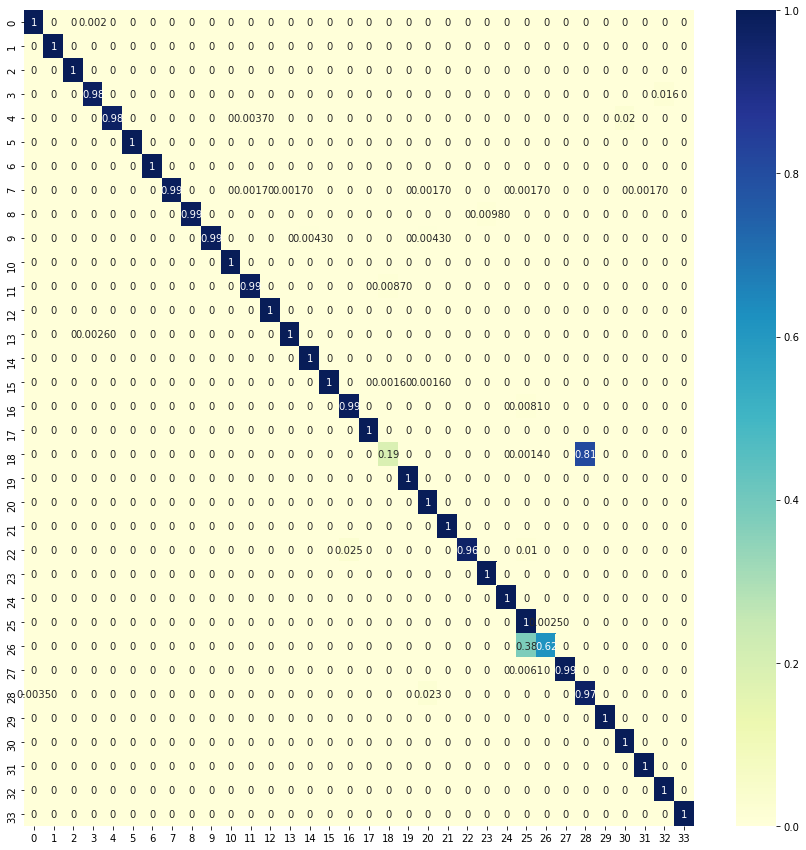

In [6]:
mat1 = bestmat/bestmat.sum(axis=1 ,keepdims = True)

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(15,15))
sns.heatmap(data=mat1,annot=True,cmap= "YlGnBu")